In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import env

### Wrangling the data...

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [3]:
df.entry[0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [4]:
def parse_log(entry):
    # Create a starting point to piece apart an entry
    parts = entry.split()
    # Set up output as a data frame for the parts 
    output = {}
    # ip will start from teh beginning
    output['ip'] = parts[0]
    # Use the 4rd part of the split and start after the 2nd char
    # Remove the 
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    # Parse the 6th part of the split starting with the 2nd char(not ")
    output['request_method'] = parts[5][1:]
    # Parse the request path using all of part 7
    output['request_path'] = parts[6]
    # Parse the version using everything but the last char (")
    output['http_version'] = parts[7][:-1]
    # Status code is all of part 9
    output['status_code'] = parts[8]
    # Size is the 10th part. Make it an integer.
    output['size'] = int(parts[9])
    # Everthing else from part 12 on and replacing " with nothing
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [5]:
# Apply the parse_log funciton
df = df.entry.apply(parse_log)
# Look at the df to see how it split
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


For the lesson, we'll add in some synthetic records to work/play with:

In [6]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [7]:
# Change the size cat to reflect size in Mb
df['size_mb'] = df['size'] / 1024 / 1024
# Set the timestamp columns to a datetime object
df.timestamp = pd.to_datetime(df.timestamp)
# Set the index based on the timestamp
df = df.set_index('timestamp')


In [8]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [9]:
df.ip.value_counts().head(10)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
Name: ip, dtype: int64

In [10]:
df.status_code.value_counts()

200    13960
499       16
301        2
Name: status_code, dtype: int64

In [11]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

### Detecting anomalies...

In [12]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
            rename(columns={'index':'ip', 'ip':'count'})

In [13]:
ip_df.head()

,ip,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [14]:
# Calculate probabity for each ip 
# ip_prob = count for each ip / total count in the dataframe
ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).\
            reset_index().rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


In [15]:
# Merge the two data frames created above into a single one using the 
# similar ip column
ip_df = ip_df.merge(ip_df2, on='ip')
ip_df.head()

,ip,count,proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


<AxesSubplot:ylabel='ip'>

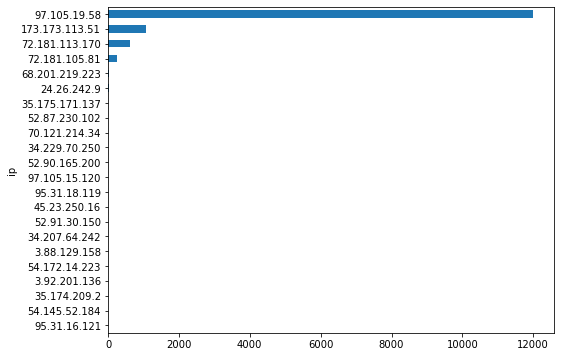

In [16]:
ip_df.set_index('ip')['count'].sort_values().plot.barh(figsize= (8, 6))

Conditional Probabilities:
- What is the probability that a certain status code is given to an IP address?

In [17]:
df.groupby(['ip', 'status_code']).size()/len(df)

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [18]:
# prob(A|B) = prob(A & B)/prob(B)
# Define the first part of the equation:
Pab = df.groupby(['ip','status_code']).size()/len(df)
Pab.head()

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
dtype: float64

In [19]:
# Define the second part of the equation:
Pb = df.groupby(['ip']).size()/len(df)
Pb.head()

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
dtype: float64

In [20]:
# Run the equation:
Pab/Pb

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [21]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [22]:
# Find where status given ip probability is less that 100%
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


##### Look at other areas...

 - What is the probability of a certain status code given a particular size?
 
         - Might be hard to define considering we're not using bins.

In [23]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [24]:
size_mb_df = pd.DataFrame(df.size_mb.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'size_mb', 'size_mb': 'count'})
size_mb_df.head()

,size_mb,count
0,0.471896,705
1,0.003396,548
2,0.003489,291
3,0.001266,229
4,0.001704,219


In [25]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

size_mb_df2 = pd.DataFrame((df.size_mb.value_counts(dropna=True))/df.size_mb.count()).reset_index().\
                rename(columns={'index': 'size_mb', 'size_mb': 'proba'})
size_mb_df2.head()

,size_mb,proba
0,0.471896,0.050436
1,0.003396,0.039204
2,0.003489,0.020818
3,0.001266,0.016383
4,0.001704,0.015667


In [26]:
# merge the two data frames create above into a single one:
size_mb_df = size_mb_df.merge(size_mb_df2, on='size_mb')
size_mb_df.head()

,size_mb,count,proba
0,0.471896,705,0.050436
1,0.003396,548,0.039204
2,0.003489,291,0.020818
3,0.001266,229,0.016383
4,0.001704,219,0.015667


<AxesSubplot:ylabel='size_mb'>

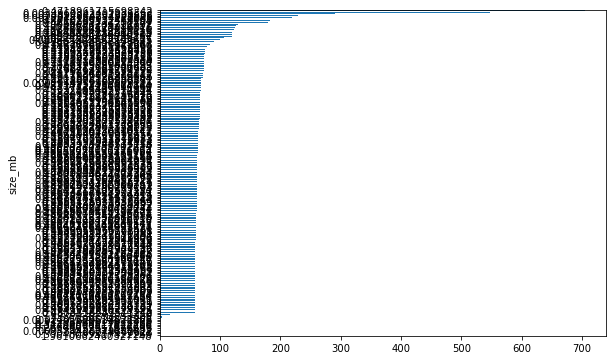

In [27]:
size_mb_df.set_index('size_mb')['count'].sort_values().plot.barh(figsize=(8,6))

In [28]:
# prob(A|B) = prob(A & B)/prob(B)
Pab = df.groupby(['size_mb', 'status_code']).size()/len(df)
Pb = df.groupby('size_mb').size()/len(df)
Pab/Pb.tail(20)

size_mb   status_code
0.000000  499            NaN
0.000040  200            NaN
0.000046  200            NaN
0.000120  200            NaN
0.000154  200            NaN
                        ... 
0.489460  200            1.0
0.489533  200            1.0
0.489937  200            1.0
1.099591  200            1.0
1.961066  200            1.0
Length: 191, dtype: float64

In [29]:
# Given a particular size, what is probability of a certain status code
status_given_size_mb = (
    df.groupby('size_mb')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_size_mb')\
    .reset_index())
status_given_size_mb

,size_mb,status_code,proba_status_given_size_mb
0,0.000000,499,1.0
1,0.000040,200,1.0
2,0.000046,200,1.0
3,0.000120,200,1.0
4,0.000154,200,1.0
...,...,...,...
186,0.489460,200,1.0
187,0.489533,200,1.0
188,0.489937,200,1.0
189,1.099591,200,1.0


In [31]:
status_given_size_mb[status_given_size_mb.proba_status_given_size_mb != 1]


,size_mb,status_code,proba_status_given_size_mb


##### DEAD END!!!

 - Try to use bins at a later date.

In [33]:
df.head(1)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
